# Setup

## Colab

In [1]:
# Mount the drive and move to dir
from google.colab import drive
drive.mount("/content/drive", force_remount = False)
%cd /content/drive/MyDrive/Coding/spread-res/runscr/

Mounted at /content/drive
/content/drive/MyDrive/Coding/spread-res/runscr


## Imports

In [ ]:
# Import importlib to reload modules and sys and os to add the path for other imports
import importlib
import os
import sys

import torch

# Append the parent directory to the path to import the necessary modules
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

# Import the model architecture
from classes.models import BertPos

# Import the utilities and the dataloader
from utils import inferutil, setuputil, trainutil

# Now reload the modules to ensure they are up-to-date
importlib.reload(setuputil)
importlib.reload(trainutil)
importlib.reload(inferutil)
importlib.reload(BertPos)

# Import the model and funcs required from utils
from classes.models.BertPos import BertPos
from utils.inferutil import infer_full, infer_one
from utils.setuputil import display_config, setup_config
from utils.trainutil import train_model

## Configuration

Default vars invisible below with their default values:

device = cuda/mps:0 (env-specific), threads = 1 to inf (env-specific), seed = 0 to inf, data_dir = ../data, rows = 100, cols = 100, tokens = 32, save_dir = ../models/ 

In [ ]:
# Restart
from utils import setuputil

importlib.reload(setuputil)
from utils.setuputil import display_config, setup_config

# Setup the config
input_config = {
    # Environment and Model Info
    "env": "local",
    "approach": "bert",
    "model_name": "BertPos",
    "model_base": "prajjwal1/bert-tiny",
    "data_ds": "manual",
    # BERT Architecture Parameters
    "vocab_size": 30522,
    "hidden_size": 32,
    "num_hidden_layers": 1,
    "num_attention_heads": 1,
    "intermediate_size": 128,
    # Training Parameters
    "batch_size": 10,
    "lr": 1e-2,
    "mu": 0.25,
    "epochs": 2,
    "patience": 2,
    "save_int": 2,
}
config = setup_config(input_config)
display_config(config)

# Define local variables from the config dictionary
DEVICE = config["DEVICE"]
THREADS = config["THREADS"]

# Data loaders and vocab
train_loader = config["train_loader"]
val_loader = config["val_loader"]
test_loader = config["test_loader"]
tokenizer = config["tokenizer"]
model_base = config["model_base"]

# Training parameters
batch_size = config["batch_size"]
lr = config["lr"]
mu = config["mu"]
epochs = config["epochs"]
patience = config["patience"]
save_int = config["save_int"]
save_dir = config["save_dir"]
save_name = config["save_name"]

Processing files: 100%|██████████| 40/40 [00:05<00:00,  7.18it/s]



40(P) = 40(G) + 0(E)


Processing files: 100%|██████████| 5/5 [00:00<00:00, 13332.18it/s]



5(P) = 5(G) + 0(E)


Processing files: 100%|██████████| 5/5 [00:00<00:00, 11935.98it/s]



5(P) = 5(G) + 0(E)

FINAL CONFIG:
{
  "env": "local",
  "approach": "bert",
  "DEVICE": "<device>",
  "THREADS": 8,
  "seed": 0,
  "model_base": "prajjwal1/bert-tiny",
  "model_name": "BertPos",
  "rows": 100,
  "cols": 100,
  "tokens": 32,
  "data_ds": "manual",
  "data_dir": "../data",
  "train_dir": "../data/manual_train",
  "val_dir": "../data/manual_val",
  "test_dir": "../data/manual_test",
  "tokenizer": "<BertTokenizerFast>",
  "vocab_size": 30522,
  "hidden_size": 32,
  "num_hidden_layers": 1,
  "num_attention_heads": 1,
  "intermediate_size": 128,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "attention_probs_dropout_prob": 0.1,
  "max_position_embeddings": 64,
  "type_vocab_size": 2,
  "initializer_range": 0.02,
  "layer_norm_eps": 1e-12,
  "pad_token_id": 0,
  "gradient_checkpointing": false,
  "train_loader": "<LoaderBert>",
  "val_loader": "<LoaderBert>",
  "test_loader": "<LoaderBert>",
  "batch_size": 10,
  "lr": 0.01,
  "mu": 0.25,
  "epochs": 2,
  "patience

# NEW TESTER

## Model Creation -> Single Example Check

In [ ]:
# Imports
import math

import torch
import torch.nn as nn
from transformers import AutoModel, BertConfig, BertModel
from transformers.models.bert.modeling_bert import BertEncoder


# Define the BertPos class
class BertPos(nn.Module):
    """A BERT-based model that combines positional and content understanding for grid-structured data.

    This model processes grid-structured input through BERT embeddings enriched with positional
    encodings for both row and column positions. It uses a combination of BERT encoding and
    positional information to create a rich representation of grid cells.

    Args:
    config (dict): Configuration dictionary containing model parameters.
    """

    def __init__(self, config):
        super().__init__()

        # Extract common params
        self.device = config["DEVICE"]
        self.rows = config["rows"]
        self.cols = config["cols"]
        self.seq_len = config["tokens"]
        self.hidden_size = config["hidden_size"]
        self.hidden_dropout_prob = config["hidden_dropout_prob"]

        # Create config to be used for both base model and encoder
        self.bert_config = BertConfig(
            vocab_size=config["vocab_size"],
            hidden_size=self.hidden_size,
            intermediate_size=config["intermediate_size"],
            num_hidden_layers=config["num_hidden_layers"],
            num_attention_heads=config["num_attention_heads"],
            hidden_act=config["hidden_act"],
            hidden_dropout_prob=self.hidden_dropout_prob,
            attention_probs_dropout_prob=config["attention_probs_dropout_prob"],
            max_position_embeddings=config["max_position_embeddings"],
            type_vocab_size=config["type_vocab_size"],
            layer_norm_eps=config["layer_norm_eps"],
            initializer_range=config["initializer_range"],
            pad_token_id=config["pad_token_id"],
            gradient_checkpointing=config["gradient_checkpointing"],
            seed=config["seed"],
        )

        # Pretrained model for cell's text content
        self.bertModel_cell = AutoModel.from_pretrained(config["model_base"])

        # Custom encoder for row/col position info
        self.bertEncoder_spatial = BertEncoder(self.bert_config)

        # Precompute pos encs for grid cells [max(rows, cols), hidden_size]
        self.pos_encodings = self.get_posEncoding()

        # Final binary classification layers wrapped sequentially
        self.binary_classifier = nn.Sequential(
            nn.Dropout(self.hidden_dropout_prob),
            nn.GELU(),
            nn.Linear(self.hidden_size, 1),
        )

    # Function to get positional encodings for cells
    def get_posEncoding(self):
        # Max of rows/cols is the number of positions we have
        max_dim = max(self.rows, self.cols)

        # Initialize the positional encoding matrix [max_dim, hidden_size]
        posEncoding = torch.zeros(max_dim, self.hidden_size, device=self.device)

        # Create [max_dim, 1] position vector
        pos = torch.arange(max_dim, dtype=torch.float, device=self.device).unsqueeze(1)

        # Compute a [hidden_size/2] vector for the exponential scaling
        # This replaces repeated pow(10000, 2i/hidden_size) calls
        div_term = torch.exp(
            torch.arange(0, self.hidden_size, 2, dtype=torch.float, device=self.device)
            * (-math.log(10000.0) / self.hidden_size)
        )

        # Apply sin to even indices and cos to odd indices
        posEncoding[:, 0::2] = torch.sin(pos * div_term)
        posEncoding[:, 1::2] = torch.cos(pos * div_term)

        # Return final matrix of all positional encodings
        return posEncoding

    # Normal optimized forward function
    def forward(self, input_ids, attention_mask):
        # Retrieve dims and initialize init tensor for posContext embeddings
        batch_size, rows, cols, seq_len = input_ids.shape
        posContext_embeddings = torch.zeros(
            (batch_size, rows * cols, self.hidden_size),
            device=input_ids.device,
        )

        # Build enriched encodings combining content and position understanding
        for cell in range(rows * cols):

            # Define row and column indices for current cell
            row = cell // self.cols
            col = cell % self.cols

            # Calculate the enriched encoding for the cell
            posContext_embeddings[:, cell, :] = (
                self.bertModel_cell(
                    input_ids=input_ids[:, row, col, :],
                    attention_mask=attention_mask[:, row, col, :],
                ).pooler_output
                + self.pos_encodings[row]
                + self.pos_encodings[col]
            )

        # Process through encoder and classification head, reshape to grid format
        S_cube = (
            self.binary_classifier(self.bertEncoder_spatial(posContext_embeddings)[0])
            .squeeze(-1)
            .reshape(batch_size, rows, cols)
        )

        # Return the S_cube
        return S_cube

In [ ]:
# Create check loader from the train_loader Dataset
check_loader = torch.utils.data.DataLoader(train_loader, batch_size=1, shuffle=False)

# Get first batch using next() and iter()
check_batch = next(iter(check_loader))

# Extract all the relevant tensors/info at loc
ex_file = check_batch["file_paths"]
ex_xtok = check_batch["x_tok"].to(DEVICE)
ex_xmasks = check_batch["x_masks"].to(DEVICE)
ex_ytok = check_batch["y_tok"]

# Print the extracted info
print(f"Filename: {ex_file}")
print(f"x_tok shape: {ex_xtok.shape}")
print(f"x_masks shape: {ex_xmasks.shape}")
print(f"y_tok shape: {ex_ytok.shape}\n")

# Define the model and move it to the device
untrained_model = BertPos(config).to(DEVICE)
# print(untrained_model)

# Model Training

In [ ]:
# Create and observe the model
untrained_model = BertPos(config).to(DEVICE)
print(untrained_model)

BertPos(
  (bertModel_cell): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 32, padding_idx=0)
      (position_embeddings): Embedding(64, 32)
      (token_type_embeddings): Embedding(2, 32)
      (LayerNorm): LayerNorm((32,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=32, out_features=32, bias=True)
              (key): Linear(in_features=32, out_features=32, bias=True)
              (value): Linear(in_features=32, out_features=32, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=32, out_features=32, bias=True)
              (LayerNorm): LayerNorm((32,), eps=1e-12, elementwise_affine=True)
    

## Training Metrics

1. GPU Model: 521 mb
2. GPU Training: 33.6 gb

3. Per Epoch Train Time: 38s
4. Per Epoch Val Time: 15s
5. Last Epoch: 16


In [ ]:
# Restart
from utils import trainutil

importlib.reload(trainutil)
from utils.trainutil import train_model

# Train with adjusted batch size
trained_model = train_model(
    untrained_model,
    train_loader,
    val_loader,
    DEVICE,
    batch_size=batch_size,
    lr=lr,
    mu=mu,
    max_epochs=epochs,
    patience=patience,
    save_int=save_int,
    save_dir=save_dir,
    save_name=save_name,
    config=config,
    isPerp=True,
)

Epoch 0


Validation Processing: 100%|██████████| 1/1 [00:33<00:00, 33.16s/it]


Train Loss: 1.2658e+00, Perplexity: 1.0000e+00
Val Loss: 8.4190e-01, Perplexity: 1.0000e+00


Epoch 1


Validation Processing: 100%|██████████| 1/1 [00:25<00:00, 25.52s/it]


Train Loss: 7.2354e-01, Perplexity: 1.0000e+00
Val Loss: 4.7282e-01, Perplexity: 1.0000e+00

Model Saved


TRAINING DONE at epoch 1, best epoch 1
Train Loss = 0.7235446125268936, Perplexity = 1.000007235472301
Val Loss = 0.47282108664512634, Perplexity = 1.0000047282220446


# Evaluation

In [ ]:
# Params
loc = 0
thresh = 0.5
infer_batch_size = 40

# # Load the pretrained weights and assign to trained model
# untrained_model.load_state_dict(
#     torch.load(
#         "../models/ber0c_bbcBertPos_manual10010032_ba40lr1e-2ep20pa2_v30kh32l1i128a1_20250210_210415.pth",
#         map_location=DEVICE,
#         weights_only=True,
#     )
# )
# trained_model = untrained_model.eval()

## Single Example


Filename: ../data/manual_train/idrportfolio-by-debt-size.xls

--- Unique Sigmoid Probabilities for Bold Cells ---
(20,0): 0.940534 | (19,0): 0.940652 | (0,19): 0.940655 | (0,0): 0.940786 | (20,1): 0.941085 | (0,1): 0.941628 | (19,1): 0.941674 | (0,18): 0.941738 | (18,0): 0.941741 | (5,18): 0.941808 | (5,19): 0.941874 | (14,1): 0.941950 | (0,13): 0.941996 | (13,1): 0.942000 | (13,0): 0.942003 | (0,12): 0.942062 | (12,0): 0.942072 | (5,17): 0.942221 | (5,13): 0.942262 | (4,15): 0.942320 | (4,16): 0.942390 | (5,12): 0.942407 | (5,6): 0.942462 | (0,9): 0.942477 | (15,1): 0.942482 | (9,0): 0.942482 | (5,14): 0.942496 | (5,7): 0.942535 | (4,14): 0.942559 | (0,11): 0.942568 | (11,0): 0.942578 | (0,8): 0.942580 | (8,0): 0.942585 | (0,14): 0.942630 | (14,0): 0.942634 | (0,2): 0.942637 | (4,17): 0.942640 | (0,10): 0.942643 | (10,0): 0.942650 | (5,15): 0.942676 | (5,8): 0.942709 | (12,1): 0.942713 | (9,1): 0.942740 | (8,1): 0.942757 | (0,7): 0.942773 | (7,0): 0.942778 | (18,1): 0.942784 | (5,11)

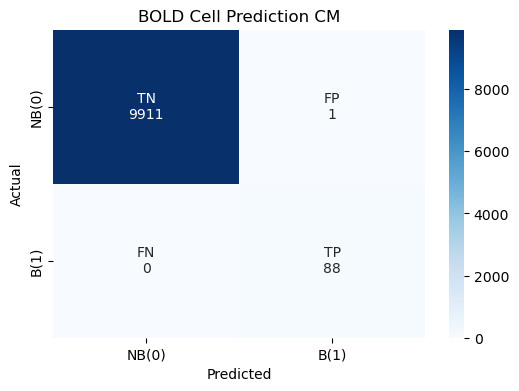


--- Predicted Grid (1 = Bold, 0 = Not Bold) ---


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
5,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
6,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0



--- Actual Grid (1 = Bold, 0 = Not Bold) ---


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
5,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
6,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Import refresh
from utils import inferutil

importlib.reload(inferutil)
from utils.inferutil import infer_full, infer_one

# Inference on single position of train_loader
infer_one(
    trained_model=trained_model,
    infer_loader=train_loader,
    loc=loc,
    threshold=thresh,
    device=DEVICE,
    approach=config["approach"],
    disp_sig=True,
)


Filename: ../data/manual_val/portfolio-by-debt-size.xls

--- Unique Sigmoid Probabilities for Bold Cells ---
(20,0): 0.94052803516387939453
(19,0): 0.94064348936080932617
(0,19): 0.94064390659332275391
(0,0): 0.94077283143997192383
(21,0): 0.94106233119964599609
(20,1): 0.94108313322067260742
(21,1): 0.94123727083206176758
(0,1): 0.94162100553512573242
(19,1): 0.94167059659957885742
(18,0): 0.94173043966293334961
(0,18): 0.94173288345336914062
(5,18): 0.94181543588638305664
(5,19): 0.94187849760055541992
(14,1): 0.94194418191909790039
(13,0): 0.94197660684585571289
(13,1): 0.94197767972946166992
(0,13): 0.94198179244995117188
(22,0): 0.94201725721359252930
(12,0): 0.94203978776931762695
(0,12): 0.94204539060592651367
(22,1): 0.94211691617965698242
(5,17): 0.94223201274871826172
(5,13): 0.94225382804870605469
(4,15): 0.94233334064483642578
(5,12): 0.94239389896392822266
(4,16): 0.94240826368331909180
(5,6): 0.94246798753738403320
(9,0): 0.94247370958328247070
(0,9): 0.94247698783874511

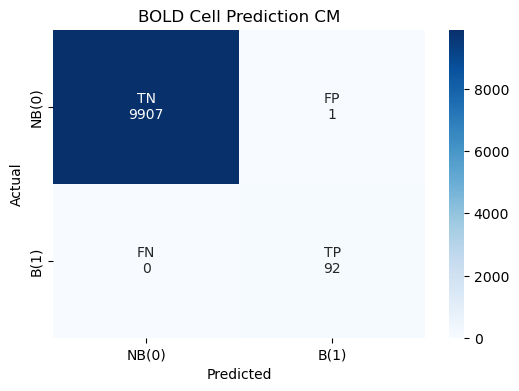


--- Predicted Grid (1 = Bold, 0 = Not Bold) ---


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
5,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
6,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0



--- Actual Grid (1 = Bold, 0 = Not Bold) ---


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
5,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
6,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Inference on single position of val_loader
infer_one(
    trained_model=trained_model,
    infer_loader=val_loader,
    loc=loc,
    threshold=thresh,
    device=DEVICE,
    approach=config["approach"],
)


Filename: ../data/manual_test/dlportfoliobyrepaymentplan.xls

--- Unique Sigmoid Probabilities for Bold Cells ---
(5,19): 0.04497866705060005188
(5,18): 0.04783393815159797668
(5,15): 0.04919987171888351440
(5,14): 0.04967035353183746338
(5,16): 0.07132287323474884033
(5,17): 0.07609485834836959839
(5,4): 0.17718510329723358154
(5,5): 0.18752911686897277832
(5,2): 0.19314080476760864258
(5,3): 0.21413528919219970703
(5,9): 0.93275582790374755859
(5,8): 0.93493092060089111328
(38,0): 0.93493813276290893555
(38,1): 0.93524760007858276367
(37,0): 0.93530100584030151367
(37,1): 0.93588459491729736328
(5,7): 0.93624109029769897461
(5,6): 0.93649446964263916016
(36,0): 0.93707454204559326172
(36,1): 0.93753767013549804688
(32,0): 0.93818795680999755859
(35,0): 0.93846446275711059570
(33,0): 0.93849921226501464844
(35,1): 0.93854999542236328125
(34,1): 0.93874293565750122070
(34,0): 0.93874996900558471680
(31,0): 0.93883466720581054688
(33,1): 0.93899780511856079102
(32,1): 0.939478993415832

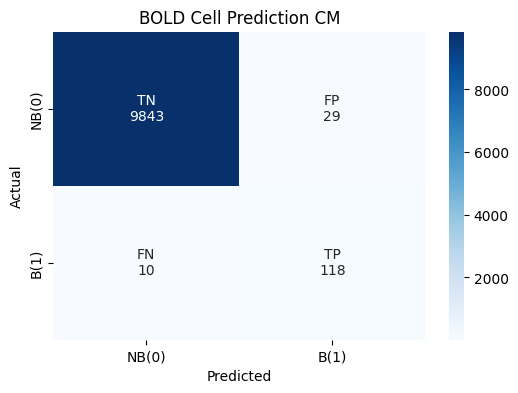


--- Predicted Grid (1 = Bold, 0 = Not Bold) ---


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,1,1,1,1,1,1,1,1,0,0,0,0,0,0,1,1
6,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
7,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0
8,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0
9,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0
10,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0
11,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0
12,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0



--- Actual Grid (1 = Bold, 0 = Not Bold) ---


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
5,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
6,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
7,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
13,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Inference on single position of test_loader
infer_one(
    trained_model=trained_model,
    infer_loader=test_loader,
    loc=loc,
    threshold=thresh,
    device=DEVICE,
    approach=config["approach"],
)

## All Examples

Batch Inference: 100%|██████████| 1/1 [00:15<00:00, 15.17s/it]


--- Aggregated Metrics Across All Batches ---

NB to B ratio: Predicted = 396652:3348 | Actual = 396714:3286
Accuracy: 99.98% | Precision: 98.15% | Recall: 100.00% | F1-Score: 0.99



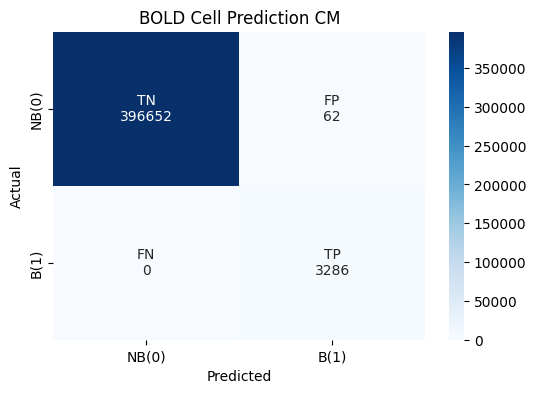

In [ ]:
# Infer across all examples of train_loader
infer_full(
    trained_model=trained_model,
    infer_loader=train_loader,
    batch_size=infer_batch_size,
    threshold=thresh,
    device=DEVICE,
    approach=config["approach"],
)

Batch Inference: 100%|██████████| 1/1 [00:14<00:00, 14.61s/it]


--- Aggregated Metrics Across All Batches ---

NB to B ratio: Predicted = 49617:383 | Actual = 49602:398
Accuracy: 99.96% | Precision: 99.22% | Recall: 95.48% | F1-Score: 0.97



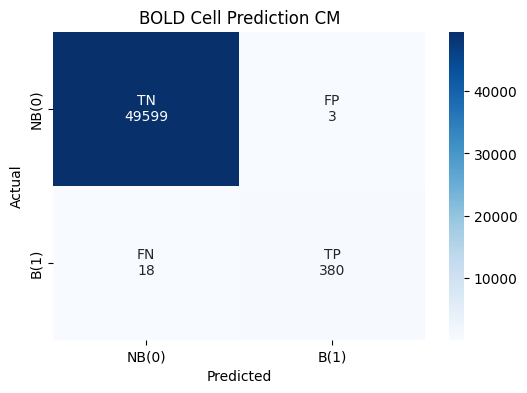

In [ ]:
# Infer across all examples of val_loader
infer_full(
    trained_model=trained_model,
    infer_loader=val_loader,
    batch_size=infer_batch_size,
    threshold=0.9331,
    device=DEVICE,
    approach=config["approach"],
)

Batch Inference: 100%|██████████| 1/1 [00:14<00:00, 14.84s/it]


--- Aggregated Metrics Across All Batches ---

NB to B ratio: Predicted = 49585:415 | Actual = 49606:394
Accuracy: 99.92% | Precision: 92.53% | Recall: 97.46% | F1-Score: 0.95



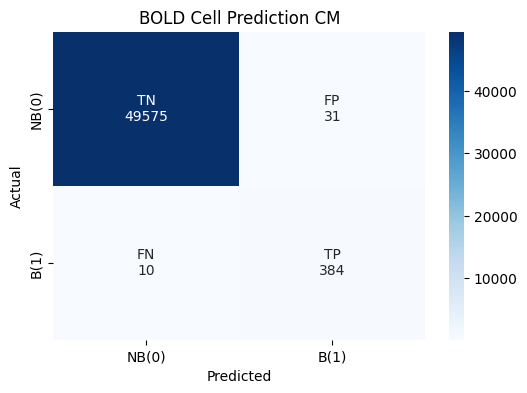

In [ ]:
# Infer across all examples of test_loader
infer_full(
    trained_model=trained_model,
    infer_loader=test_loader,
    batch_size=infer_batch_size,
    threshold=thresh,
    device=DEVICE,
    approach=config["approach"],
)